

# Installation

In [ ]:
!pip install pyspark

In [ ]:
from pyspark import SparkContext, SparkConf

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('readJSON').getOrCreate()

In [ ]:
from pyspark.sql.functions import *
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/Shared drives/CS 631 Project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shared drives/CS 631 Project




# Preliminary Data Analysis

In [ ]:
business = spark.read.json("/content/drive/Shared drives/CS 631 Project/yelp_academic_dataset_business.json")
business.cache()
review = spark.read.json("/content/drive/Shared drives/CS 631 Project/yelp_academic_dataset_review.json")
review.cache()

DataFrame[business_id: string, cool: bigint, date: string, funny: bigint, review_id: string, stars: double, text: string, useful: bigint, user_id: string]

In [ ]:
split_col = split(business['categories'], ', ')
new_business = business.withColumn('category1', split_col.getItem(0)).withColumn('category2', split_col.getItem(1)).withColumn('category3', split_col.getItem(2)).drop("categories")
restaurant = new_business.filter(new_business.category1 == "Restaurants")
restaurant.cache()
restaurant.createOrReplaceTempView("restaurant")

In [ ]:
restaurant.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

# Simple Recommender

In [ ]:
#take Q = 40
#score=p+5(1-exp(−q/Q)) where p is stars and q is review count
top_100 = spark.sql("""select name, stars, review_count, float(stars)+5*(1-exp(-int(review_count)/40)) as score, address, city, state, business_id from restaurant order by score DESC""")

In [ ]:
top_100.show(100)

+--------------------+-----+------------+-----------------+--------------------+--------------+-----+--------------------+
|                name|stars|review_count|            score|             address|          city|state|         business_id|
+--------------------+-----+------------+-----------------+--------------------+--------------+-----+--------------------+
|        Brew Tea Bar|  5.0|        1827|             10.0|7380 S Rainbow Bl...|     Las Vegas|   NV|IhNASEZ3XnBHmuuVn...|
|     Cocina Madrigal|  5.0|        1107|9.999999999995214|      4044 S 16th St|       Phoenix|   AZ|9MVKjEMN5T59uzG1x...|
|Green Corner Rest...|  5.0|         858|9.999999997582574|1038 W Southern A...|          Mesa|   AZ|16d3BlncEyCTzb0Gx...|
|              Karved|  5.0|         651|9.999999572607091|3957 S Maryland Pkwy|     Las Vegas|   NV|cePE3rCuUOVSCCAHS...|
|Not Your Typical ...|  5.0|         645|9.999999503440284|1166 South Gilber...|       Gilbert|   AZ|52yWGkwnrQXIjvuMj...|
|       Baretto 

In [ ]:
c1 = spark.sql("""select category2 as category, count(distinct(business_id)) as number1 from restaurant group by category order by number1 DESC""")
c1.show()

+--------------------+-------+
|            category|number1|
+--------------------+-------+
|               Pizza|   1658|
|             Mexican|   1209|
|             Chinese|   1149|
|           Fast Food|    995|
|          Sandwiches|    985|
|             Italian|    771|
|                Food|    745|
|American (Traditi...|    678|
|             Burgers|    649|
|  Breakfast & Brunch|    537|
|      American (New)|    522|
|            Japanese|    521|
|          Sushi Bars|    377|
|                Thai|    372|
|               Cafes|    371|
|              Indian|    355|
|          Vietnamese|    348|
|           Nightlife|    299|
|            Barbeque|    281|
|                Bars|    279|
+--------------------+-------+
only showing top 20 rows



In [ ]:
c2 = spark.sql("""select category3 as category , count(distinct(business_id)) as number2 from restaurant group by category order by number2 DESC""")
c2.show()

+--------------------+-------+
|            category|number2|
+--------------------+-------+
|                null|   7926|
|           Fast Food|    978|
|                Food|    865|
|             Burgers|    508|
|          Sandwiches|    460|
|American (Traditi...|    414|
|           Nightlife|    359|
|               Pizza|    358|
|  Breakfast & Brunch|    354|
|             Italian|    323|
|                Bars|    317|
|             Chinese|    300|
|             Mexican|    293|
|      American (New)|    261|
|            Japanese|    223|
|          Sushi Bars|    221|
|        Coffee & Tea|    213|
|       Chicken Wings|    205|
|               Salad|    177|
|             Seafood|    176|
+--------------------+-------+
only showing top 20 rows



In [ ]:
restaurant_category=c1.join(c2,"category","outer")
restaurant_category.createOrReplaceTempView("restaurant_category")
restaurant_category = spark.sql("""select category, number1+number2 as number from restaurant_category order by number DESC""")
restaurant_category.show(20)

+--------------------+------+
|            category|number|
+--------------------+------+
|               Pizza|  2016|
|           Fast Food|  1973|
|                Food|  1610|
|             Mexican|  1502|
|             Chinese|  1449|
|          Sandwiches|  1445|
|             Burgers|  1157|
|             Italian|  1094|
|American (Traditi...|  1092|
|  Breakfast & Brunch|   891|
|      American (New)|   783|
|            Japanese|   744|
|           Nightlife|   658|
|          Sushi Bars|   598|
|                Bars|   596|
|               Cafes|   541|
|              Indian|   457|
|                Thai|   451|
|       Chicken Wings|   434|
|             Seafood|   425|
+--------------------+------+
only showing top 20 rows



In [ ]:
category_ls = restaurant_category.select("category").toPandas()["category"].tolist()
print(category_ls)

['Pizza', 'Fast Food', 'Food', 'Mexican', 'Chinese', 'Sandwiches', 'Burgers', 'Italian', 'American (Traditional)', 'Breakfast & Brunch', 'American (New)', 'Japanese', 'Nightlife', 'Sushi Bars', 'Bars', 'Cafes', 'Indian', 'Thai', 'Chicken Wings', 'Seafood', 'Vietnamese', 'Barbeque', 'Coffee & Tea', 'Asian Fusion', 'Mediterranean', 'Salad', 'Delis', 'Steakhouses', 'Diners', 'Greek', 'French', 'Korean', 'Canadian (New)', 'Middle Eastern', 'Caribbean', 'Event Planning & Services', 'Buffets', 'Bakeries', 'Tex-Mex', 'Vegetarian', 'Caterers', 'Tacos', 'Hot Dogs', 'Desserts', 'Latin American', 'Noodles', 'Soup', 'Vegan', 'Ice Cream & Frozen Yogurt', 'Halal', 'Gluten-Free', 'Comfort Food', 'Specialty Food', 'Pakistani', 'Chicken Shop', 'Sports Bars', 'Fish & Chips', 'Pubs', 'Juice Bars & Smoothies', 'Gastropubs', 'Soul Food', 'Food Trucks', 'Dim Sum', 'Portuguese', 'Beer', 'Southern', 'Filipino', 'Hawaiian', 'Cajun/Creole', 'Cocktail Bars', 'Tapas Bars', 'Lounges', 'Ethnic Food', 'Arts & Entert

In [ ]:
def top_select(category,n):
    df = spark.sql("select name, stars, review_count, float(stars)+5*(1-exp(-int(review_count)/40)) as score, category2, category3, address, city, state from restaurant order by score DESC").toPandas()
    top_n = df.loc[(df['category2'] == category) | (df['category3'] == category)].head(n)
    return top_n

In [ ]:
top_select("abcd",5)

,name,stars,review_count,score,category2,category3,address,city,state


In [ ]:
restaurant.show(20)

+--------------------+--------------------+--------------------+----------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+-----------+------------------+--------------+
|             address|          attributes|         business_id|      city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|  category1|         category2|     category3|
+--------------------+--------------------+--------------------+----------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+-----------+------------------+--------------+
|15480 Bayview Ave...|[,, u'none',,,,, ...|eBEfgOPG7pvFhb2wc...|    Aurora|[11:0-22:0, 11:0-...|      1|   44.0109618|    -79.448677|     Philthy Phillys|    L4G 7J1|           4|  4.5|   ON|Restaurants|      Cheesesteaks|   Poutineries|
|  843 Kipling Avenue|[,, u'none', {'ro...|rVBPQ




# Sentiment Analysis

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from pyspark.sql.types import IntegerType
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
import re
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
top = spark.sql("select Name, COUNT(DISTINCT business_id) as {0} from restaurant group by Name order by Number_of_Restaurants DESC".format('Number_of_Restaurants'))

In [ ]:
top.show(10)

+--------------------+---------------------+
|                Name|Number_of_Restaurants|
+--------------------+---------------------+
|  Subway Restaurants|                  290|
|          McDonald's|                  261|
|           Taco Bell|                  146|
|             Wendy's|                  119|
|         Burger King|                  113|
|           Pizza Hut|                  102|
|              Subway|                  100|
|     Jack in the Box|                   94|
|Chipotle Mexican ...|                   77|
|      Domino's Pizza|                   73|
+--------------------+---------------------+
only showing top 10 rows



In [ ]:
review = review.withColumnRenamed("stars","review_stars")
review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- review_stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [ ]:
combined = review.join(broadcast(new_business), 'business_id', 'right')
combined.createOrReplaceTempView("combined")

In [ ]:
subway = spark.sql("""select * from combined where name = 'Subway Restaurants' or name = 'Subway' """)
subway.cache()
subway.createOrReplaceTempView("subway")

In [ ]:
subway.show(10)

+--------------------+----+-------------------+-----+--------------------+------------+--------------------+------+--------------------+--------------------+--------------------+--------+--------------------+-------+------------+---------------+------------------+-----------+------------+-----+-----+----------+-----------+-----------+
|         business_id|cool|               date|funny|           review_id|review_stars|                text|useful|             user_id|             address|          attributes|    city|               hours|is_open|    latitude|      longitude|              name|postal_code|review_count|stars|state| category1|  category2|  category3|
+--------------------+----+-------------------+-----+--------------------+------------+--------------------+------+--------------------+--------------------+--------------------+--------+--------------------+-------+------------+---------------+------------------+-----------+------------+-----+-----+----------+-----------+--

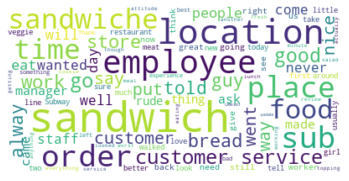

In [ ]:


text = " ".join(subway.select("text").toPandas()["text"].tolist())
# Create and generate a word cloud image:
stopwords = set(STOPWORDS)
stopwords.update(["one", "subway", "said", "even", "lot","asked","really","got","know","make","ordered","want"])
# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords,max_font_size=50, max_words=100, background_color="white").generate(text)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:

def classify(rating):
    if rating <=2:
        return -1
    if rating >= 4:
        return 1
    return 0

func_udf = udf(classify, IntegerType())
subway = subway.withColumn('sentiment',func_udf(subway['review_stars']))

In [ ]:
subway_sentiment = subway.select("review_stars","sentiment","text").toPandas()


In [ ]:

color = sns.color_palette()
fig = px.histogram(subway_sentiment, x="review_stars")
fig.update_traces(marker_color="turquoise",marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Review Score')
fig.show()

In [ ]:
fig = px.histogram(subway_sentiment, x="sentiment")
fig.update_traces(marker_color="turquoise",marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Sentiment Score')
fig.show()

In [ ]:
features = subway_sentiment.iloc[:, 2].values
labels = subway_sentiment.iloc[:, 1].values

In [ ]:

processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()
    processed_features.append(processed_feature)

In [ ]:
vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)
predictions = text_classifier.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[806   0  59]
 [ 77   2  91]
 [ 81   0 459]]
              precision    recall  f1-score   support

          -1       0.84      0.93      0.88       865
           0       1.00      0.01      0.02       170
           1       0.75      0.85      0.80       540

    accuracy                           0.80      1575
   macro avg       0.86      0.60      0.57      1575
weighted avg       0.83      0.80      0.76      1575

0.8044444444444444


In [ ]:
from sklearn.tree import DecisionTreeClassifier 
dtree_model = DecisionTreeClassifier(max_depth = 4).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 

print(confusion_matrix(y_test,dtree_predictions))
print(classification_report(y_test,dtree_predictions))
print(accuracy_score(y_test, dtree_predictions))

[[736   0 129]
 [ 91   0  79]
 [160   1 379]]
              precision    recall  f1-score   support

          -1       0.75      0.85      0.79       865
           0       0.00      0.00      0.00       170
           1       0.65      0.70      0.67       540

    accuracy                           0.71      1575
   macro avg       0.46      0.52      0.49      1575
weighted avg       0.63      0.71      0.67      1575

0.707936507936508


In [ ]:
from sklearn.svm import SVC 
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test) 
  
print(confusion_matrix(y_test,svm_predictions))
print(classification_report(y_test,svm_predictions))
print(accuracy_score(y_test, svm_predictions))

[[808  19  38]
 [ 59  35  76]
 [ 72  26 442]]
              precision    recall  f1-score   support

          -1       0.86      0.93      0.90       865
           0       0.44      0.21      0.28       170
           1       0.79      0.82      0.81       540

    accuracy                           0.82      1575
   macro avg       0.70      0.65      0.66      1575
weighted avg       0.79      0.82      0.80      1575

0.8158730158730159


In [ ]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train) 
knn_predictions = knn.predict(X_test)  

print(confusion_matrix(y_test,knn_predictions))
print(classification_report(y_test,knn_predictions))
print(accuracy_score(y_test, knn_predictions))

[[755  70  40]
 [ 83  59  28]
 [128 138 274]]
              precision    recall  f1-score   support

          -1       0.78      0.87      0.82       865
           0       0.22      0.35      0.27       170
           1       0.80      0.51      0.62       540

    accuracy                           0.69      1575
   macro avg       0.60      0.58      0.57      1575
weighted avg       0.73      0.69      0.70      1575

0.6907936507936508


In [ ]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB().fit(X_train, y_train) 
gnb_predictions = gnb.predict(X_test) 

print(confusion_matrix(y_test,gnb_predictions))
print(classification_report(y_test,gnb_predictions))
print(accuracy_score(y_test, gnb_predictions))

[[447 331  87]
 [ 36  95  39]
 [ 51 298 191]]
              precision    recall  f1-score   support

          -1       0.84      0.52      0.64       865
           0       0.13      0.56      0.21       170
           1       0.60      0.35      0.45       540

    accuracy                           0.47      1575
   macro avg       0.52      0.48      0.43      1575
weighted avg       0.68      0.47      0.53      1575

0.4653968253968254


# 

# Recommender

In [ ]:
user = spark.read.json("/content/drive/Shared drives/CS 631 Project/yelp_academic_dataset_user.json")
user.cache()

DataFrame[average_stars: double, compliment_cool: bigint, compliment_cute: bigint, compliment_funny: bigint, compliment_hot: bigint, compliment_list: bigint, compliment_more: bigint, compliment_note: bigint, compliment_photos: bigint, compliment_plain: bigint, compliment_profile: bigint, compliment_writer: bigint, cool: bigint, elite: string, fans: bigint, friends: string, funny: bigint, name: string, review_count: bigint, useful: bigint, user_id: string, yelping_since: string]

In [ ]:
user.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [ ]:
tip = spark.read.json("/content/drive/Shared drives/CS 631 Project/yelp_academic_dataset_tip.json")
tip.cache()
tip.printSchema()



root
 |-- business_id: string (nullable = true)
 |-- compliment_count: long (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)



In [ ]:
#user_review = review.filter("user_id"== "zZUnPeh2hEp0WydbAZEOOg")
user_review = review.filter(review.user_id== "ntlvfPzc8eglqvk92iDIAw")
user_review.show()

KeyboardInterrupt: ignored

In [ ]:
#zZUnPeh2hEp0WydbAZEOOg
user.select("user_id","review_count").show(20,False)

+----------------------+------------+
|user_id               |review_count|
+----------------------+------------+
|ntlvfPzc8eglqvk92iDIAw|553         |
|FOBRPlBHa3WPHFB5qYDlVg|564         |
|zZUnPeh2hEp0WydbAZEOOg|60          |
|QaELAmRcDc5TfJEylaaP8g|206         |
|xvu8G900tezTzbbfqmTKvA|485         |
|z5_82komKV3mI4ASGe2-FQ|186         |
|ttumcu6hWshk_EJVWrduDg|12          |
|f4_MRNHvN-yRn7EA8YWRxg|822         |
|UYACF30806j2mfbB5vdmJA|14          |
|QG13XBbgHWydzThRBGJtyw|218         |
|f6YuZP6iennHFVlnFJOXLQ|5           |
|I_6wY8_RsewziNnKhGZg4g|405         |
|q-v8elVPvKz0KvK69QSj1Q|666         |
|HwPGLzF_uXB3MF8bc5u5dg|6           |
|y4UuVowA9i3zj2hHyRMfHw|51          |
|1WBxJ2r3A2QYfRSEzgcmkQ|315         |
|-TT5e-YQU9xLb1JAGCGkQw|180         |
|6bbHSJ0PrgSxh7e5nigKMw|15          |
|4VmuXuSRhv5UxYUy3tMpiQ|106         |
|pVU2DdtBFppBAX5G5t3rcw|193         |
+----------------------+------------+
only showing top 20 rows

